# Import libraries and data

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
#read csv and display columns
df = pd.read_csv('data/merged_df_for_causality_v2.csv', parse_dates=['Date'])
display(df.columns)

#drop 2007 and 2008 (no ipc values available)
df = df[df['year'] > 2008]

#make seperate df for rubkona and koch
df_rubkona = df.loc[df['district'] == "Rubkona"]
df_koch = df.loc[df['district'] == "Koch"]

#fill nan ipc values
df_rubkona_filled = df_rubkona.fillna(method='ffill')
df_rubkona_filled = df_rubkona.fillna(method='bfill')
df_koch_filled = df_koch.fillna(method='ffill')
df_koch_filled = df_koch.fillna(method='bfill')

Index(['Date', 'country', 'district_code', 'district', 'centx', 'centy',
       'year_month', 'year', 'month', 'ipc', 'ha', 'ndvi_mean', 'ndvi_anom',
       'rain_mean', 'rain_anom', 'et_mean', 'et_anom', 'count_violence',
       'sum_fatalities', 'food_price_idx', 'area', 'cropland_pct', 'pop',
       'ruggedness_mean', 'pasture_pct', 'conflict_1#', 'conflict_2#',
       'total_conflict#'],
      dtype='object')

# Settings

In [3]:
# variables to look at with granger (all models)
variables = ['ndvi_mean', 'ndvi_anom','rain_mean', 'rain_anom', 'et_mean', 'et_anom','total_conflict#', 'conflict_1#', 'conflict_2#','count_violence']

#variables not needed for train or test
no_variables = ['country', 'district_code', 'district', 'centx', 'centy','year_month','month','ha','sum_fatalities','food_price_idx','area','cropland_pct','pop','ruggedness_mean', 'pasture_pct']

#minimum of unique values for granger (standard = 1, if error occurs make higher)
min_unique = 1

#which granger analysis test
test = "params_ftest"

#granger significance point (standard = 0.05, lower is stricter)
granger_sig = 0.05

#set training years for models (do not train over 2009 because there is almost no ipc data)
koch_1_train_years = [2010, 2011, 2012, 2013]
koch_2_train_years = [2014, 2015, 2016, 2017]
rubkona_1_train_years = [2010, 2011, 2012, 2013]
rubkona_2_train_years = [2014, 2015, 2016, 2017]

#maximum lag for granger
lag_setting = 12 #peronal set max by preference (I have done 1 year)
lag_years = min(len(koch_1_train_years),len(koch_2_train_years),len(rubkona_1_train_years),len(rubkona_2_train_years)) #maximum = (number of years * 4) - 2
lag = min(lag_setting, lag_years) #gets minumum from personal setting and max from granger model

# Granger analysis

In [4]:
#create subset of train years for granger analysis
koch_1_train_filled = df_koch_filled[df_koch_filled['year'].isin(koch_1_train_years)]
koch_2_train_filled = df_koch_filled[df_koch_filled['year'].isin(koch_2_train_years)]
rubkona_1_train_filled = df_rubkona_filled[df_rubkona_filled['year'].isin(rubkona_1_train_years)]
rubkona_2_train_filled = df_rubkona_filled[df_rubkona_filled['year'].isin(rubkona_2_train_years)]

#create list of lags
lags = []
for i in range(lag):
    i=i+1
    lags.append(i)

Koch 1

In [5]:
#create df for granger results
granger_koch_1 = pd.DataFrame()
granger_koch_1['lag'] = lags
granger_koch_1 = granger_koch_1.set_index('lag')

#run analysis for all variables
for variable in variables:
    #check if column is not constant (otherwise granger will not work)
    if len(koch_1_train_filled[variable].unique()) > min_unique:
        #calculate granger causality
        results = grangercausalitytests(koch_1_train_filled[['ipc',variable]], maxlag=lag, verbose = False)
        p_values = [round(results[i+1][0][test][1], 4) for i in range(lag)]
        granger_koch_1[variable] = p_values

#show dataframe with granger results
#granger_koch_1.head(lag)

#find usable variables and lags
koch_1_lags = {}
for variable in granger_koch_1.columns.tolist():
    koch_1_lags[variable] = granger_koch_1.index[granger_koch_1[variable] < granger_sig].tolist()

#print(koch_1_lags)

Koch 2

In [6]:
#create df for granger results
granger_koch_2 = pd.DataFrame()
granger_koch_2['lag'] = lags
granger_koch_2 = granger_koch_2.set_index('lag')

#run analysis for all variables
for variable in variables:
    #check if column is not constant (otherwise granger will not work)
    if len(koch_2_train_filled[variable].unique()) > min_unique:
        #calculate granger causality
        results = grangercausalitytests(koch_2_train_filled[['ipc',variable]], maxlag=lag, addconst = True, verbose = False)
        p_values = [round(results[i+1][0][test][1], 4) for i in range(lag)]
        granger_koch_2[variable] = p_values

#show dataframe with granger results
#granger_koch_2.head(lag)

#find usable variables and lags
koch_2_lags = {}
for variable in granger_koch_2.columns.tolist():
    koch_2_lags[variable] = granger_koch_2.index[granger_koch_2[variable] < granger_sig].tolist()

#print(koch_2_lags)

Rubkona 1

In [7]:
#create df for granger results
granger_rubkona_1 = pd.DataFrame()
granger_rubkona_1['lag'] = lags
granger_rubkona_1 = granger_rubkona_1.set_index('lag')

#run analysis for all variables
for variable in variables:
    #check if column is not constant (otherwise granger will not work)
    if len(rubkona_1_train_filled[variable].unique()) > min_unique:
        #calculate granger causality
        results = grangercausalitytests(rubkona_1_train_filled[['ipc',variable]], maxlag=lag, verbose = False)
        p_values = [round(results[i+1][0][test][1], 4) for i in range(lag)]
        granger_rubkona_1[variable] = p_values

#show dataframe with granger results
#granger_rubkona_1.head(lag)

#find usable variables and lags
rubkona_1_lags = {}
for variable in granger_rubkona_1.columns.tolist():
    rubkona_1_lags[variable] = granger_rubkona_1.index[granger_rubkona_1[variable] < granger_sig].tolist()

#print(rubkona_1_lags)

Rubkona 2

In [8]:
#create df for granger results
granger_rubkona_2 = pd.DataFrame()
granger_rubkona_2['lag'] = lags
granger_rubkona_2 = granger_rubkona_2.set_index('lag')

#run analysis for all variables
for variable in variables:
    #check if column is not constant (otherwise granger will not work)
    if len(rubkona_2_train_filled[variable].unique()) > min_unique:
        #calculate granger causality
        results = grangercausalitytests(rubkona_2_train_filled[['ipc',variable]], maxlag=lag, verbose = False)
        p_values = [round(results[i+1][0][test][1], 4) for i in range(lag)]
        granger_rubkona_2[variable] = p_values

#show dataframe with granger results
#granger_rubkona_2.head(lag)

#find usable variables and lags
rubkona_2_lags = {}
for variable in granger_rubkona_2.columns.tolist():
    rubkona_2_lags[variable] = granger_rubkona_2.index[granger_rubkona_2[variable] < granger_sig].tolist()

#print(rubkona_2_lags)

Usable variables

In [9]:
#usable variables

print("Koch 1:")
print(koch_1_lags)
print("\nKoch 2:")
print(koch_2_lags)
print("\nRubkona 1:")
print(rubkona_1_lags)
print("\nRubkona 2:")
print(rubkona_2_lags)

Koch 1:
{'ndvi_mean': [1, 3, 4], 'ndvi_anom': [], 'rain_mean': [1], 'rain_anom': [], 'et_mean': [1], 'et_anom': [], 'total_conflict#': [], 'conflict_1#': [], 'conflict_2#': [], 'count_violence': []}

Koch 2:
{'ndvi_mean': [], 'ndvi_anom': [], 'rain_mean': [], 'rain_anom': [], 'et_mean': [], 'et_anom': [4], 'total_conflict#': [1, 4], 'conflict_1#': [1, 4], 'conflict_2#': [], 'count_violence': []}

Rubkona 1:
{'ndvi_mean': [1, 3, 4], 'ndvi_anom': [], 'rain_mean': [1], 'rain_anom': [], 'et_mean': [1], 'et_anom': [], 'total_conflict#': [], 'conflict_1#': [], 'conflict_2#': [], 'count_violence': []}

Rubkona 2:
{'ndvi_mean': [], 'ndvi_anom': [], 'rain_mean': [], 'rain_anom': [], 'et_mean': [], 'et_anom': [], 'total_conflict#': [1, 2], 'conflict_1#': [1, 2], 'conflict_2#': [1, 2], 'count_violence': []}


# Create train and test sets

In [10]:
koch_1_train = df_koch[df_koch['year'].isin(koch_1_train_years)].drop(no_variables,axis=1)
koch_1_test = df_koch.drop(no_variables,axis=1)
koch_2_train = df_koch[df_koch['year'].isin(koch_2_train_years)].drop(no_variables,axis=1)
koch_2_test = df_koch.drop(no_variables,axis=1)

rubkona_1_train = df_rubkona[df_rubkona['year'].isin(rubkona_1_train_years)].drop(no_variables,axis=1)
rubkona_1_test = df_rubkona.drop(no_variables,axis=1)
rubkona_2_train = df_rubkona[df_rubkona['year'].isin(rubkona_2_train_years)].drop(no_variables,axis=1)
rubkona_2_test = df_rubkona.drop(no_variables,axis=1)

#create usefull lagged variables in train df
koch_1_lagged_columns = []
for variable in koch_1_lags:
    for lag in koch_1_lags[variable]:
        lag_column = f"{variable}_lag{lag}"
        koch_1_lagged_columns.append(lag_column)
        koch_1_train[lag_column] = koch_1_train[variable].shift(lag)
        koch_1_test[lag_column] = koch_1_test[variable].shift(lag)
koch_1_train = koch_1_train.dropna()
koch_1_test = koch_1_test.dropna()

koch_2_lagged_columns = []
for variable in koch_2_lags:
    for lag in koch_2_lags[variable]:
        lag_column = f"{variable}_lag{lag}"
        koch_2_lagged_columns.append(lag_column)
        koch_2_train[lag_column] = koch_2_train[variable].shift(lag)
        koch_2_test[lag_column] = koch_2_test[variable].shift(lag)
koch_2_train = koch_2_train.dropna()
koch_2_test = koch_2_test.dropna()

rubkona_1_lagged_columns = []
for variable in rubkona_1_lags:
    for lag in rubkona_1_lags[variable]:
        lag_column = f"{variable}_lag{lag}"
        rubkona_1_lagged_columns.append(lag_column)
        rubkona_1_train[lag_column] = rubkona_1_train[variable].shift(lag)
        rubkona_1_test[lag_column] = rubkona_1_test[variable].shift(lag)
rubkona_1_train = rubkona_1_train.dropna()
rubkona_1_test = rubkona_1_test.dropna()

rubkona_2_lagged_columns = []
for variable in rubkona_2_lags:
    for lag in rubkona_2_lags[variable]:
        lag_column = f"{variable}_lag{lag}"
        rubkona_2_lagged_columns.append(lag_column)
        rubkona_2_train[lag_column] = rubkona_2_train[variable].shift(lag)
        rubkona_2_test[lag_column] = rubkona_2_test[variable].shift(lag)
rubkona_2_train = rubkona_2_train.dropna()
rubkona_2_test = rubkona_2_test.dropna()

# Modeling

Koch 1

In [11]:
X_train = koch_1_train[koch_1_lagged_columns]
y_train = koch_1_train['ipc']
X_train = sm.add_constant(X_train)

X_test = koch_1_test[koch_1_lagged_columns]
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train,X_train).fit()
model.save("models/regression_model_koch_1")

#print(model.summary())

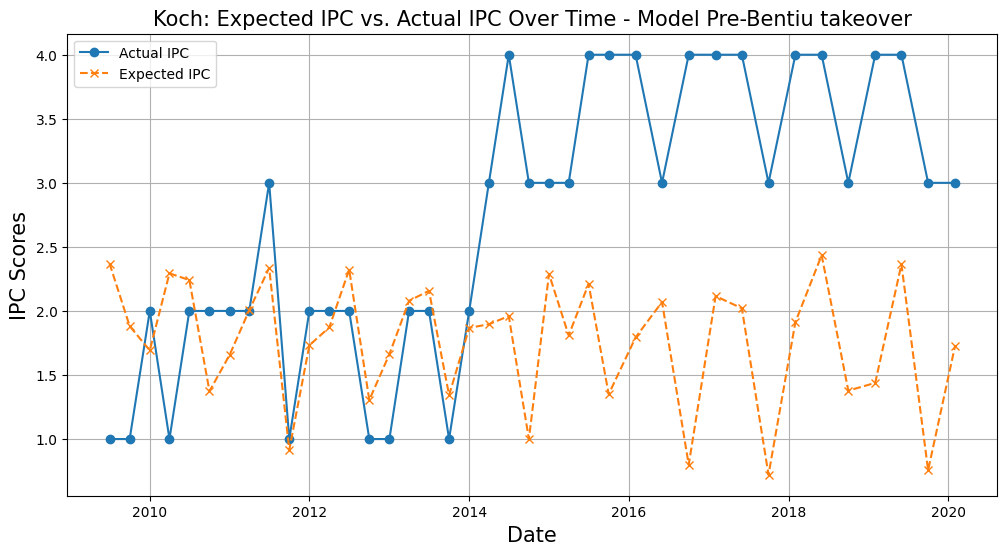

Used variables:
['ndvi_mean_lag1', 'ndvi_mean_lag3', 'ndvi_mean_lag4', 'rain_mean_lag1', 'et_mean_lag1']


In [12]:
# Predict the IPC values based on the model
y_pred = model.predict(X_test)

# Create a time series plot to compare expected vs. actual IPC scores
plt.figure(figsize=(12, 6))
plt.plot(koch_1_test['Date'], koch_1_test['ipc'], label='Actual IPC', linestyle='-', marker='o')
plt.plot(koch_1_test['Date'], y_pred, label='Expected IPC', linestyle='--', marker='x')

# Add labels, a legend, and a title
plt.xlabel('Date', fontsize=15)
plt.ylabel('IPC Scores', fontsize=15)
plt.title('Koch: Expected IPC vs. Actual IPC Over Time - Model Pre-Bentiu takeover', fontsize=15)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
print("Used variables:")
print(koch_1_lagged_columns)

In [13]:
#calculate r2 before and after 2014

predicted_before_2014 = y_pred[:18]
predicted_after_2014 = y_pred[18:]

actual_before_2014 = koch_1_test['ipc'][:18]
actual_after_2014 = koch_1_test['ipc'][18:]

print(r2_score(actual_before_2014, predicted_before_2014))
print(r2_score(actual_after_2014, predicted_after_2014))

print(mean_squared_error(actual_before_2014, predicted_before_2014))
print(mean_squared_error(actual_after_2014, predicted_after_2014))


-0.0520184200347551
-9.433174327369619
0.3506728066782517
3.596014734150072


Koch 2

In [14]:
X_train = koch_2_train[koch_2_lagged_columns]
y_train = koch_2_train['ipc']
X_train = sm.add_constant(X_train)

X_test = koch_2_test[koch_2_lagged_columns]
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train,X_train).fit()
model.save("models/regression_model_koch_2")

#print(model.summary())

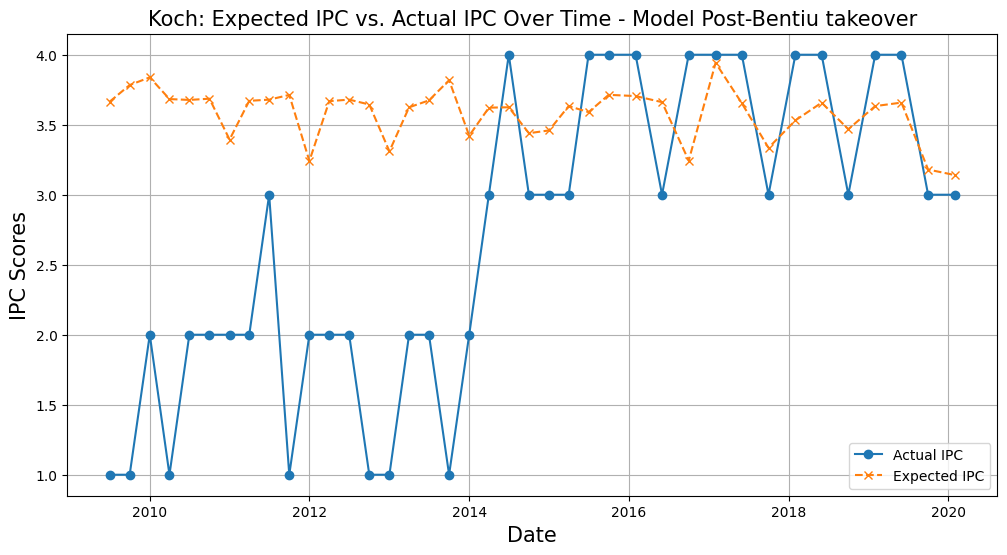

Used variables:
['et_anom_lag4', 'total_conflict#_lag1', 'total_conflict#_lag4', 'conflict_1#_lag1', 'conflict_1#_lag4']


In [15]:
# Predict the IPC values based on the model
y_pred = model.predict(X_test)

# Create a time series plot to compare expected vs. actual IPC scores
plt.figure(figsize=(12, 6))
plt.plot(koch_2_test['Date'], koch_2_test['ipc'], label='Actual IPC', linestyle='-', marker='o')
plt.plot(koch_2_test['Date'], y_pred, label='Expected IPC', linestyle='--', marker='x')

# Add labels, a legend, and a title
plt.xlabel('Date', fontsize=15)
plt.ylabel('IPC Scores', fontsize=15)
plt.title('Koch: Expected IPC vs. Actual IPC Over Time - Model Post-Bentiu takeover', fontsize=15)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
print("Used variables:")
print(koch_2_lagged_columns)

In [16]:
#calculate r2 before and after 2014

predicted_before_2014 = y_pred[:18]
predicted_after_2014 = y_pred[18:]

actual_before_2014 = koch_2_test['ipc'][:18]
actual_after_2014 = koch_2_test['ipc'][18:]

print(r2_score(actual_before_2014, predicted_before_2014))
print(r2_score(actual_after_2014, predicted_after_2014))

print(mean_squared_error(actual_before_2014, predicted_before_2014))
print(mean_squared_error(actual_after_2014, predicted_after_2014))

-11.747867113905523
0.19922042929651296
4.2492890379685075
0.27600565702251706


Rubkona 1

In [17]:
X_train = rubkona_1_train[rubkona_1_lagged_columns]
y_train = rubkona_1_train['ipc']
X_train = sm.add_constant(X_train)

X_test = rubkona_1_test[rubkona_1_lagged_columns]
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train,X_train).fit()
model.save("models/regression_model_rubkona_1")

#print(model.summary())

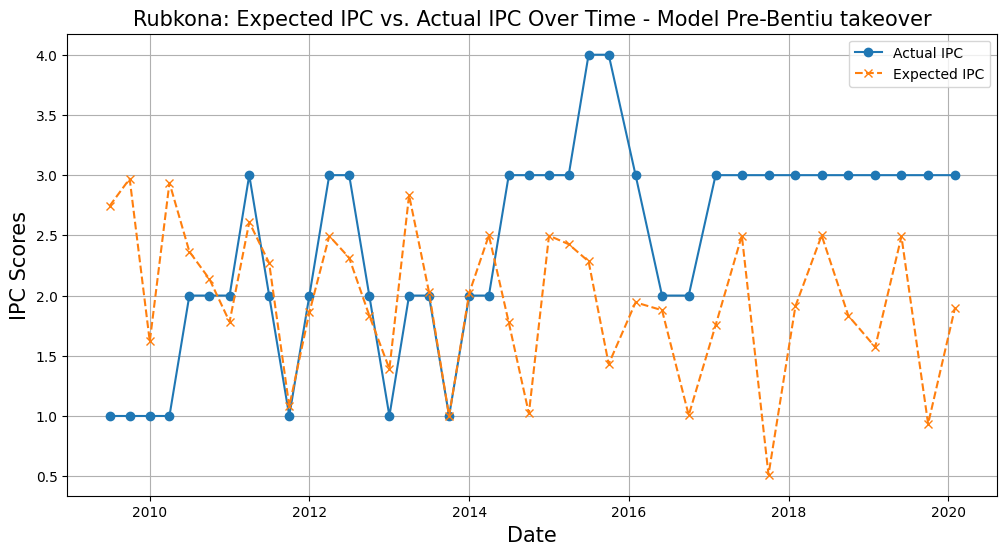

Used variables:
['ndvi_mean_lag1', 'ndvi_mean_lag3', 'ndvi_mean_lag4', 'rain_mean_lag1', 'et_mean_lag1']


In [18]:
# Predict the IPC values based on the model
y_pred = model.predict(X_test)

# Create a time series plot to compare expected vs. actual IPC scores
plt.figure(figsize=(12, 6))
plt.plot(rubkona_1_test['Date'], rubkona_1_test['ipc'], label='Actual IPC', linestyle='-', marker='o')
plt.plot(rubkona_1_test['Date'], y_pred, label='Expected IPC', linestyle='--', marker='x')

# Add labels, a legend, and a title
plt.xlabel('Date', fontsize=15)
plt.ylabel('IPC Scores', fontsize=15)
plt.title('Rubkona: Expected IPC vs. Actual IPC Over Time - Model Pre-Bentiu takeover', fontsize=15)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
print("Used variables:")
print(rubkona_1_lagged_columns)

In [19]:
#calculate r2 before and after 2014

predicted_before_2014 = y_pred[:18]
predicted_after_2014 = y_pred[18:]

actual_before_2014 = rubkona_1_test['ipc'][:18]
actual_after_2014 = rubkona_1_test['ipc'][18:]

print(r2_score(actual_before_2014, predicted_before_2014))
print(r2_score(actual_after_2014, predicted_after_2014))

print(mean_squared_error(actual_before_2014, predicted_before_2014))
print(mean_squared_error(actual_after_2014, predicted_after_2014))

-0.4383419395781136
-5.2786374499244815
0.7280496237370698
1.7369473217478155


Rubkona 2

In [20]:
X_train = rubkona_2_train[rubkona_2_lagged_columns]
y_train = rubkona_2_train['ipc']
X_train = sm.add_constant(X_train)

X_test = rubkona_2_test[rubkona_2_lagged_columns]
X_test = sm.add_constant(X_test)

model = sm.OLS(y_train,X_train).fit()
model.save("models/regression_model_rubkona_2")

#print(model.summary())

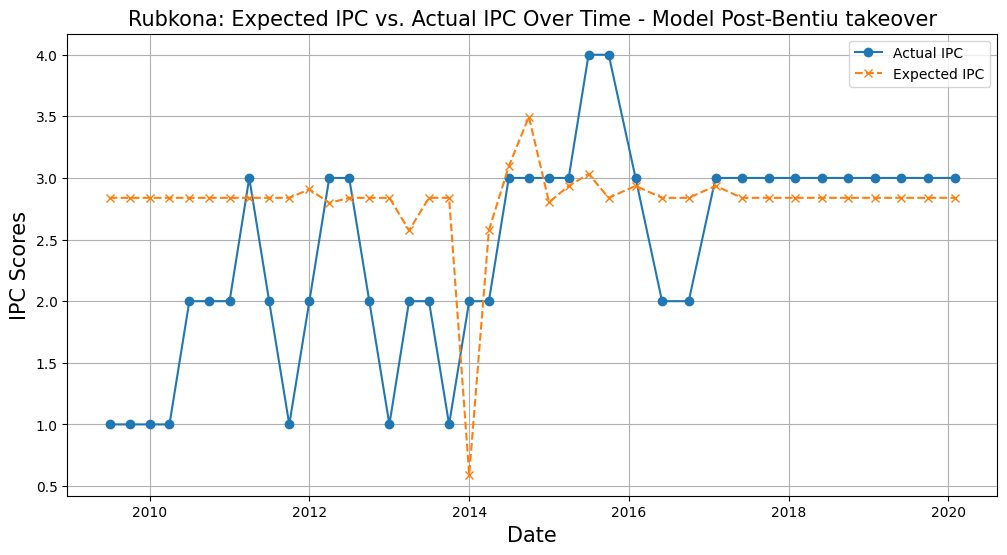

Used variables:
['total_conflict#_lag1', 'total_conflict#_lag2', 'conflict_1#_lag1', 'conflict_1#_lag2', 'conflict_2#_lag1', 'conflict_2#_lag2']


In [21]:
# Predict the IPC values based on the model
y_pred = model.predict(X_test)

# Create a time series plot to compare expected vs. actual IPC scores
plt.figure(figsize=(12, 6))
plt.plot(rubkona_2_test['Date'], rubkona_2_test['ipc'], label='Actual IPC', linestyle='-', marker='o')
plt.plot(rubkona_2_test['Date'], y_pred, label='Expected IPC', linestyle='--', marker='x')

# Add labels, a legend, and a title
plt.xlabel('Date', fontsize=15)
plt.ylabel('IPC Scores', fontsize=15)
plt.title('Rubkona: Expected IPC vs. Actual IPC Over Time - Model Post-Bentiu takeover', fontsize=15)
plt.legend()

# Show the plot
plt.grid(True)
plt.show()
print("Used variables:")
print(rubkona_2_lagged_columns)

In [22]:
#calculate r2 before and after 2014

predicted_before_2014 = y_pred[:18]
predicted_after_2014 = y_pred[18:]

actual_before_2014 = rubkona_2_test['ipc'][:18]
actual_after_2014 = rubkona_2_test['ipc'][18:]

print(r2_score(actual_before_2014, predicted_before_2014))
print(r2_score(actual_after_2014, predicted_after_2014))

print(mean_squared_error(actual_before_2014, predicted_before_2014))
print(mean_squared_error(actual_after_2014, predicted_after_2014))

-2.1972179790011714
-0.1269567672005929
1.6183449029512103
0.31176581768361067
